In [2]:
"""
Amazon Reviews Sentiment Analysis
Complete implementation with Logistic Regression, KNN, and VADER comparison
Customized for amazonreviews.tsv (Tab-Separated Values) with 'label' and 'review' columns
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')





In [4]:
# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("User Reviews Classification using Logistic Regression")
print("="*80)

User Reviews Classification using Logistic Regression


In [6]:
print("\n[STEP 1] Loading Data...")

data = pd.read_csv('user_comments.tsv', sep='\t', encoding='utf-8')
print(f"✓ Dataset loaded successfully from 'user_comments.tsv'!")


[STEP 1] Loading Data...
✓ Dataset loaded successfully from 'user_comments.tsv'!


In [7]:
df = data.copy()

In [8]:
print(f"  Shape: {df.shape}")
print(f"  Columns: {df.columns.tolist()}")

  Shape: (10000, 2)
  Columns: ['label', 'review']


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  object
 1   review  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [10]:
df.head(10)


,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."
5,pos,an absolute masterpiece: I am quite sure any o...
6,neg,"Buyer beware: This is a self-published book, a..."
7,pos,Glorious story: I loved Whisper of the wicked ...
8,pos,A FIVE STAR BOOK: I just finished reading Whis...
9,pos,Whispers of the Wicked Saints: This was a easy...


In [11]:
df.describe()

,label,review
count,10000,10000
unique,2,10000
top,neg,Stuning even for the non-gamer: This sound tra...
freq,5097,1


In [12]:
if 'label' not in df.columns or 'review' not in df.columns:
    print("\n⚠ Looking for correct column names...")
    print(f"Available columns: {df.columns.tolist()}")
    
    # Try to find label column
    for col in df.columns:
        if col.lower() in ['label', 'sentiment', 'rating', 'score']:
            df = df.rename(columns={col: 'label'})
            print(f"✓ Renamed '{col}' to 'label'")
            break
    
    # Try to find review column
    for col in df.columns:
        if col.lower() in ['review', 'text', 'comment', 'content']:
            df = df.rename(columns={col: 'review'})
            print(f"✓ Renamed '{col}' to 'review'")
            break


In [13]:
df.head(1)

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...


In [14]:
df.label.value_counts()

label
neg    5097
pos    4903
Name: count, dtype: int64

In [15]:
print("\n" + "="*80)
print("[STEP 2] Checking for Null Values...")
print("="*80)

null_counts = df.isnull().sum()
print("\n--- Null Value Count ---")
print(null_counts)

null_percentage = (df.isnull().sum() / len(df)) * 100
print("\n--- Null Percentage ---")
for col, pct in null_percentage.items():
    if pct > 0:
        print(f"  {col}: {pct:.2f}%")

if null_counts.sum() > 0:
    print(f"\n⚠ Found {null_counts.sum()} null values")
    print("Removing rows with null values...")
    df = df.dropna()
    print(f"✓ Dataset shape after removing nulls: {df.shape}")
else:
    print("\n✓ No null values found!")


[STEP 2] Checking for Null Values...

--- Null Value Count ---
label     0
review    0
dtype: int64

--- Null Percentage ---

✓ No null values found!


In [16]:
print(df['label'].unique())

['pos' 'neg']


In [ ]:
print("\n" + "="*80)
print("[STEP 3] Data Exploration...")
print("="*80)

# Check unique labels
print("\n--- Unique Labels ---")
print(df['label'].unique())
print(f"Number of unique labels: {df['label'].nunique()}")

# Standardize labels to 'pos' and 'neg' if needed
label_mapping = {
    'positive': 'pos', 'pos': 'pos', '1': 'pos', 1: 'pos', 'good': 'pos',
    'negative': 'neg', 'neg': 'neg', '0': 'neg', 0: 'neg', 'bad': 'neg'
}

if not all(df['label'].isin(['pos', 'neg'])):
    print("\n⚠ Standardizing label format...")
    df['label'] = df['label'].astype(str).str.lower().map(lambda x: label_mapping.get(x, x))
    print(f"✓ Labels standardized: {df['label'].unique()}")

# Check Sentiment distribution
print("\n--- Sentiment Label Distribution ---")
sentiment_counts = df['label'].value_counts()
print(sentiment_counts)
print(f"\nTotal samples: {len(df)}")
print(f"Positive samples: {sentiment_counts.get('pos', 0)} ({sentiment_counts.get('pos', 0)/len(df)*100:.2f}%)")
print(f"Negative samples: {sentiment_counts.get('neg', 0)} ({sentiment_counts.get('neg', 0)/len(df)*100:.2f}%)")

# Check for class imbalance
if len(sentiment_counts) > 1:
    class_ratio = sentiment_counts.max() / sentiment_counts.min()
    print(f"\nClass imbalance ratio: {class_ratio:.2f}:1")
    if class_ratio > 2:
        print("⚠ Warning: Dataset is imbalanced. Using stratified sampling.")
    else:
        print("✓ Dataset is reasonably balanced.")


[STEP 3] Data Exploration...

--- Unique Labels ---
['pos' 'neg']
Number of unique labels: 2

--- Sentiment Label Distribution ---
label
neg    5097
pos    4903
Name: count, dtype: int64

Total samples: 10000
Positive samples: 4903 (49.03%)
Negative samples: 5097 (50.97%)

Class imbalance ratio: 1.04:1
✓ Dataset is reasonably balanced.


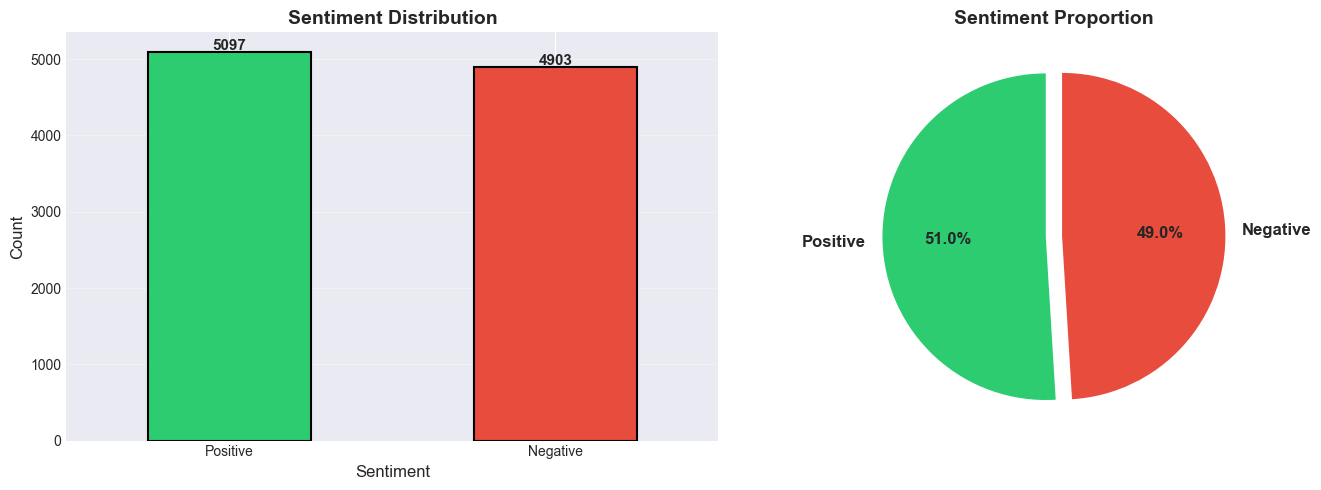

In [ ]:
# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
colors = ['#2ecc71', '#e74c3c']  # Green for positive, Red for negative
sentiment_counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_title('Classification Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classification', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Positive', 'Negative'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(sentiment_counts):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold', fontsize=11)

# Pie chart
axes[1].pie(sentiment_counts, labels=['Positive', 'Negative'], autopct='%1.1f%%',
            colors=colors, startangle=90, explode=(0.05, 0.05),
            textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Sentiment Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()






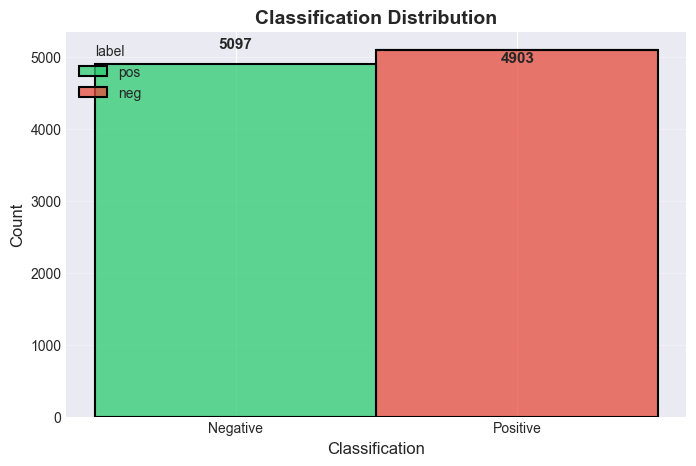

In [27]:
# distributio plot 
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='label', hue='label', multiple='stack', palette=colors, edgecolor='black', linewidth=1.5)
plt.title('Classification Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Classification', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(sentiment_counts):
    plt.text(i, v + 20, str(v), ha='center', fontweight='bold', fontsize=11)
plt.show()  

In [19]:
# Review length analysis
df['review_length'] = df['review'].astype(str).str.len()
df['word_count'] = df['review'].astype(str).str.split().str.len()

print("\n--- Review Length Statistics ---")
print(df.groupby('label')[['review_length', 'word_count']].describe())

# Sample reviews
print("\n--- Sample Positive Reviews ---")
pos_reviews = df[df['label'] == 'pos']['review'].head(3)
for i, review in enumerate(pos_reviews):
    print(f"{i+1}. {str(review)[:150]}...")

print("\n--- Sample Negative Reviews ---")
neg_reviews = df[df['label'] == 'neg']['review'].head(3)
for i, review in enumerate(neg_reviews):
    print(f"{i+1}. {str(review)[:150]}...")




--- Review Length Statistics ---
      review_length                                                      \
              count        mean         std    min    25%    50%    75%   
label                                                                     
neg          5097.0  449.159309  235.109588  101.0  252.0  407.0  615.0   
pos          4903.0  427.817459  243.008547  101.0  222.0  370.0  594.0   

              word_count                                                        
          max      count       mean        std   min   25%   50%    75%    max  
label                                                                           
neg    1015.0     5097.0  81.744556  42.487401  15.0  47.0  74.0  112.0  212.0  
pos    1015.0     4903.0  77.274934  43.460589  14.0  40.0  68.0  106.0  207.0  

--- Sample Positive Reviews ---
1. Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate

In [64]:
# # ============================================================================
# # STEP 4: TEXT PREPROCESSING
# # ============================================================================
# print("\n" + "="*80)
# print("[STEP 4] Text Preprocessing...")
# print("="*80)

# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

# def preprocess_text(text):
#     """Clean and preprocess text"""
#     text = str(text).lower()
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text)
#     text = re.sub(r'<.*?>', '', text)
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     text = re.sub(r'\s+', ' ', text).strip()
#     words = text.split()
#     words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
#     return ' '.join(words)

# print("Preprocessing reviews (this may take a moment)...")
# df['clean_review'] = df['review'].apply(preprocess_text)
# print("✓ Text preprocessing completed!")

# print("\n--- Example: Before vs After Preprocessing ---")
# for i in range(min(3, len(df))):
#     print(f"\n{i+1}. Original ({df['label'].iloc[i]}):")
#     print(f"   {str(df['review'].iloc[i])[:120]}...")
#     print(f"   Cleaned:")
#     print(f"   {df['clean_review'].iloc[i][:120]}...")

# # Remove empty reviews after preprocessing
# original_len = len(df)
# df = df[df['clean_review'].str.len() > 0]
# removed = original_len - len(df)
# if removed > 0:
#     print(f"\n⚠ Removed {removed} reviews that became empty after preprocessing")
#     print(f"✓ Final dataset size: {len(df)}")




# ============================================================================
# STEP 4: TEXT PREPROCESSING (REVISED with Negation Handling)
# ============================================================================
print("\n" + "="*80)
print("[STEP 4] Text Preprocessing (with Negation Handling)...")
print("="*80)

lemmatizer = WordNetLemmatizer()
# We keep the standard stop word set
stop_words = set(stopwords.words('english'))
# Define common negation terms
NEGATION_WORDS = ['not', 'no', 'never', 'n\'t']


def preprocess_text(text):
    """Clean, handle negation, and preprocess text."""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    
    # 1. Tokenize (keeping apostrophes for "n't" to be handled correctly)
    words = re.findall(r'\b\w+\b|\S', text) # Simple tokenization
    
    # 2. NEGATION HANDLING LOOP
    new_words = []
    i = 0
    while i < len(words):
        word = words[i]
        
        # Check if the word is a negation word AND there is a word immediately following it
        if word in NEGATION_WORDS and i + 1 < len(words):
            next_word = words[i+1]
            
            # Combine them: 'not' + 'good' -> 'not_good'
            new_words.append(f"not_{next_word}")
            i += 2  # Skip the next word since it's now part of the negation tag
        
        # Handle cases like "didn't" by replacing with "not_" and skipping the "n't"
        elif word.endswith("n't"):
            # If "didn't", we'll just process it as a single token but it won't be in stop_words
            new_words.append(word)
            i += 1
            
        # Standard words
        else:
            new_words.append(word)
            i += 1
            
    # 3. Final Cleaning, Lemmatization, and Stop Word Removal
    # Join and clean again to remove any stray punctuation/symbols
    final_text = ' '.join(new_words)
    final_text = re.sub(r'[^a-zA-Z_]', ' ', final_text).strip() # only keep letters and underscores
    final_words = final_text.split()
    
    processed_words = [
        lemmatizer.lemmatize(word) for word in final_words 
        if word not in stop_words and len(word) > 2
    ]
    
    return ' '.join(processed_words)

print("Preprocessing reviews (this may take a moment)...")
df['clean_review'] = df['review'].apply(preprocess_text)
print("✓ Text preprocessing completed!")

print("\n--- Example: Before vs After Preprocessing ---")
# Use a clear example to demonstrate the fix if possible
test_phrases = [
    "This is not good at all, I'm so disappointed.", # Should result in 'not_good'
    "The camera was excellent and never failed me.",  # Should result in 'not_failed'
    "It was great, but I didn't get the right size."
]
print(f"\nExample of Negation Fix:")
for phrase in test_phrases:
    print(f"Original: {phrase}")
    print(f"Cleaned:  {preprocess_text(phrase)}")


# Print standard examples
for i in range(min(3, len(df))):
    print(f"\n{i+1}. Original ({df['label'].iloc[i]}):")
    print(f"   {str(df['review'].iloc[i])[:120]}...")
    print(f"   Cleaned:")
    print(f"   {df['clean_review'].iloc[i][:120]}...")

# Remove empty reviews after preprocessing
original_len = len(df)
df = df[df['clean_review'].str.len() > 0]
removed = original_len - len(df)
if removed > 0:
    print(f"\n⚠ Removed {removed} reviews that became empty after preprocessing")
    print(f"✓ Final dataset size: {len(df)}")



[STEP 4] Text Preprocessing (with Negation Handling)...
Preprocessing reviews (this may take a moment)...
✓ Text preprocessing completed!

--- Example: Before vs After Preprocessing ---

Example of Negation Fix:
Original: This is not good at all, I'm so disappointed.
Cleaned:  not_good disappointed
Original: The camera was excellent and never failed me.
Cleaned:  camera excellent not_failed
Original: It was great, but I didn't get the right size.
Cleaned:  great get right size

1. Original (pos):
   Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recome...
   Cleaned:
   stuning even non gamer sound track beautiful paint senery mind well would recomend even people hate vid game music playe...

2. Original (pos):
   The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I...
   Cleaned:
   best soundtrack ever anything reading lot review saying best game sou

In [65]:
# ============================================================================
# STEP 5: FEATURE EXTRACTION
# ============================================================================
print("\n" + "="*80)
print("[STEP 5] Feature Extraction (TF-IDF Vectorization)...")
print("="*80)

# vectorizer = TfidfVectorizer(
#     max_features=5000,
#     ngram_range=(1, 2),
#     min_df=2,
#     max_df=0.9
# )


vectorizer = TfidfVectorizer(
    max_features=10000, # Increased features
    ngram_range=(1, 3), # Increased n-gram range
    min_df=2,
    max_df=0.85         # Slight decrease in max_df
)

X = vectorizer.fit_transform(df['clean_review'])
y = df['label']

print(f"✓ Feature matrix shape: {X.shape}")
print(f"✓ Number of samples: {X.shape[0]}")
print(f"✓ Number of features: {X.shape[1]}")
print(f"✓ Sparsity: {(1.0 - X.nnz / (X.shape[0] * X.shape[1])) * 100:.2f}%")




[STEP 5] Feature Extraction (TF-IDF Vectorization)...
✓ Feature matrix shape: (10000, 10000)
✓ Number of samples: 10000
✓ Number of features: 10000
✓ Sparsity: 99.65%


In [66]:
# ============================================================================
# STEP 6: TRAIN-TEST SPLIT
# ============================================================================
print("\n" + "="*80)
print("[STEP 6] Splitting Data (80% Train, 20% Test)...")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"✓ Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(df)*100:.1f}%)")

print("\n--- Train Set Distribution ---")
print(y_train.value_counts())
print("\n--- Test Set Distribution ---")
print(y_test.value_counts())




[STEP 6] Splitting Data (80% Train, 20% Test)...
✓ Training set size: 8000 (80.0%)
✓ Test set size: 2000 (20.0%)

--- Train Set Distribution ---
label
neg    4078
pos    3922
Name: count, dtype: int64

--- Test Set Distribution ---
label
neg    1019
pos     981
Name: count, dtype: int64


In [67]:
# ============================================================================
# STEP 7: MODEL TRAINING - LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*80)
print("[STEP 7A] Training Logistic Regression Model...")
print("="*80)

lr_model = LogisticRegression(max_iter=1000, random_state=88, C=1.0, solver='lbfgs')
print("Training Logistic Regression...")
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("✓ Logistic Regression training completed!")





[STEP 7A] Training Logistic Regression Model...
Training Logistic Regression...
✓ Logistic Regression training completed!


In [80]:
import joblib
import os

# Create a models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the model and vectorizer
joblib.dump(lr_model, "models/classifier.pkl")
joblib.dump(vectorizer, "models/vectorizer.pkl")

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!


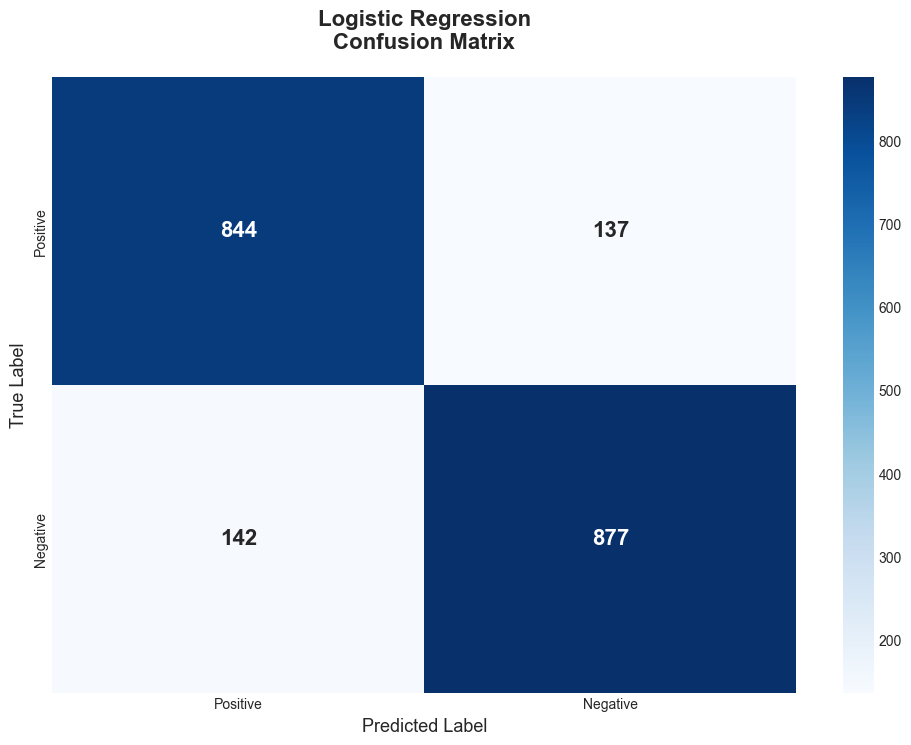

In [69]:
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=['pos', 'neg'])


plt.figure(figsize=(12, 8))

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'], 
            annot_kws={'size': 16, 'weight': 'bold'}) # Removed the 'ax' argument

plt.title('Logistic Regression\nConfusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)

plt.show()

In [70]:

print("\n" + "="*80)
print("[STEP 9] Performance Metrics...")
print("="*80)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr, pos_label='pos')
lr_recall = recall_score(y_test, y_pred_lr, pos_label='pos')
lr_f1 = f1_score(y_test, y_pred_lr, pos_label='pos')

print("\n" + "="*60)
print("LOGISTIC REGRESSION")
print("="*60)
print(f"Accuracy:  {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")
print("\n" + classification_report(y_test, y_pred_lr, target_names=['Positive', 'Negative']))




[STEP 9] Performance Metrics...

LOGISTIC REGRESSION
Accuracy:  0.8605 (86.05%)
Precision: 0.8560
Recall:    0.8603
F1-Score:  0.8582

              precision    recall  f1-score   support

    Positive       0.86      0.86      0.86      1019
    Negative       0.86      0.86      0.86       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



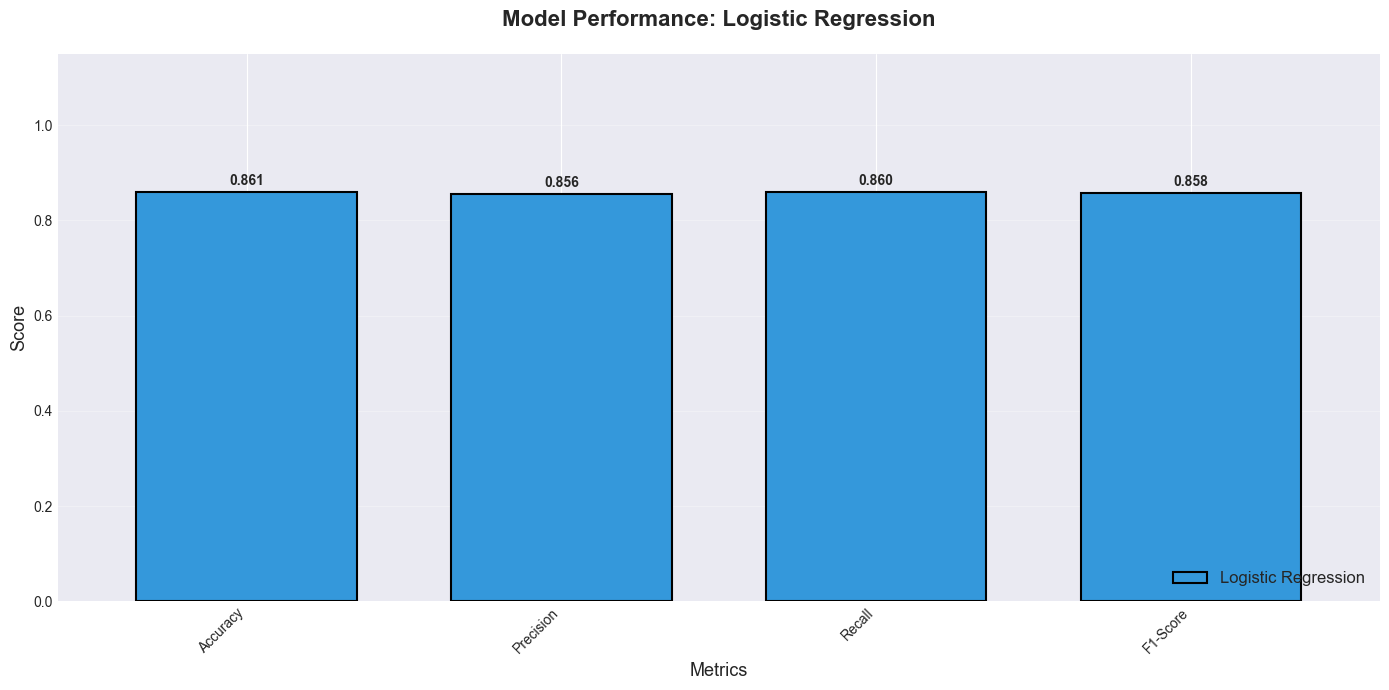

In [71]:
# Performance comparison chart
metrics_df = pd.DataFrame({
    'Logistic Regression': [lr_accuracy, lr_precision, lr_recall, lr_f1],
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

fig, ax = plt.subplots(figsize=(14, 7))
metrics_df.plot(kind='bar', ax=ax, width=0.7, color=['#3498db'], edgecolor='black', linewidth=1.5)
plt.title('Model Performance: Logistic Regression', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Score', fontsize=13)
plt.xlabel('Metrics', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1.15])
plt.legend(loc='lower right', fontsize=12)
plt.grid(axis='y', alpha=0.3)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontweight='bold')

plt.tight_layout()
plt.show()

In [72]:

print("\n" + "="*80)
print("[STEP 10] Testing with Random Sentiments...")
print("="*80)

test_reviews = [
    "This is absolutely amazing! Best product ever!",
    "Terrible experience, worst purchase ever",
    "Pretty decent, works fine for the price",
    "I love this! Excellent quality!",
    "Horrible quality, broke immediately",
    "Good value for money, satisfied",
    "Not impressed, expected better",
    "Outstanding! Exceeded expectations!",
    "Average product, nothing special",
    "Complete waste of money!"
]

test_clean = [preprocess_text(review) for review in test_reviews]
test_vectors = vectorizer.transform(test_clean)
lr_predictions = lr_model.predict(test_vectors)

print("\n" + "="*80)
for i, review in enumerate(test_reviews):
    print(f"\n📝 Review {i+1}: \"{review}\"")
    print(f"   LR:  {lr_predictions[i].upper()}")
   




[STEP 10] Testing with Random Sentiments...


📝 Review 1: "This is absolutely amazing! Best product ever!"
   LR:  POS

📝 Review 2: "Terrible experience, worst purchase ever"
   LR:  NEG

📝 Review 3: "Pretty decent, works fine for the price"
   LR:  POS

📝 Review 4: "I love this! Excellent quality!"
   LR:  POS

📝 Review 5: "Horrible quality, broke immediately"
   LR:  NEG

📝 Review 6: "Good value for money, satisfied"
   LR:  POS

📝 Review 7: "Not impressed, expected better"
   LR:  NEG

📝 Review 8: "Outstanding! Exceeded expectations!"
   LR:  POS

📝 Review 9: "Average product, nothing special"
   LR:  NEG

📝 Review 10: "Complete waste of money!"
   LR:  NEG


In [81]:
import joblib 

def load_and_predict(text_to_analyze: str):
    """Loads models using joblib and predicts sentiment for a given text."""
    model = None
    vectorizer = None
    
    # 1. Load the vectorizer and classifier using JOBLIB
    try:
        # Changed pickle.load to joblib.load
        with open('models/vectorizer.pkl', 'rb') as f:
            vectorizer = joblib.load(f)
        with open('models/classifier.pkl', 'rb') as f:
            model = joblib.load(f)
        print("✓ Models loaded successfully using joblib.")
    except FileNotFoundError:
        return {"error": "Model files not found. Check the 'models/' path."}
    except Exception as e:
        # This will now catch joblib-related errors if they occur
        return {"error": f"Failed to load models with joblib: {e}"}

    # ... (rest of the prediction logic remains the same)
    # 2. Preprocess the input text
    cleaned_text = preprocess_text(text_to_analyze)
    
    if not cleaned_text:
        return {"sentiment": "neutral", "confidence": 0.0, "text": text_to_analyze}

    # 3. Vectorize the text using the LOADED vectorizer
    features = vectorizer.transform([cleaned_text])

    # 4. Predict sentiment and probabilities
    prediction = model.predict(features)[0]
    probabilities = model.predict_proba(features)[0]
    
    # Simple output format
    return {
        "text": text_to_analyze,
        "sentiment": prediction,
        "confidence": max(probabilities),
        "probabilities": {
            "positive": probabilities[1],
            "negative": probabilities[0]
        }
    }

In [84]:
load_and_predict("I think it's good for the weather")

✓ Models loaded successfully using joblib.


{'text': "I think it's good for the weather",
 'sentiment': 'pos',
 'confidence': np.float64(0.738148817751622),
 'probabilities': {'positive': np.float64(0.738148817751622),
  'negative': np.float64(0.261851182248378)}}

In [ ]:
# import pickle
# import re
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from typing import Dict, Any

# # Ensure NLTK data is downloaded if not already present
# try:
#     nltk.data.find('corpora/stopwords')
#     nltk.data.find('corpora/wordnet')
#     nltk.data.find('corpora/omw-1.4')
# except Exception:
#     print("Downloading NLTK data...")
#     nltk.download('stopwords', quiet=True)
#     nltk.download('wordnet', quiet=True)
#     nltk.download('omw-1.4', quiet=True)


# # --- Re-define Preprocessing Function ---
# # (Must be identical to the one used during training!)
# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

# def preprocess_text(text: str) -> str:
#     """Clean and preprocess text using the same logic as training."""
#     text = str(text).lower()
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text)
#     text = re.sub(r'<.*?>', '', text)
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     text = re.sub(r'\s+', ' ', text).strip()
#     words = text.split()
#     words = [lemmatizer.lemmatize(word) for word in words
#              if word not in stop_words and len(word) > 2]
#     return ' '.join(words)

# def load_and_predict(text_to_analyze: str) -> Dict[str, Any]:
#     """Loads models and predicts sentiment for a given text."""
#     model = None
#     vectorizer = None
    
#     # 1. Load the vectorizer and classifier
#     try:
#         with open('lr_models/vectorizer.pkl', 'rb') as f:
#             vectorizer = pickle.load(f)
#         with open('lr_models/classifier.pkl', 'rb') as f:
#             model = pickle.load(f)
#         print("✓ Models loaded successfully.")
#     except FileNotFoundError:
#         return {"error": "Model files not found. Check the 'lr_models/' path."}
#     except Exception as e:
#         return {"error": f"Failed to load models: {e}"}

#     # 2. Preprocess the input text
#     cleaned_text = preprocess_text(text_to_analyze)
    
#     if not cleaned_text:
#         return {"sentiment": "neutral", "confidence": 0.0, "text": text_to_analyze}

#     # 3. Vectorize the text using the LOADED vectorizer
#     features = vectorizer.transform([cleaned_text])

#     # 4. Predict sentiment and probabilities
#     prediction = model.predict(features)[0]
#     probabilities = model.predict_proba(features)[0]
    
#     # Assuming the classes are ['neg', 'pos'] which is standard for LR
#     prob_pos = probabilities[1]
#     prob_neg = probabilities[0]
    
#     # Simple output format
#     return {
#         "text": text_to_analyze,
#         "sentiment": prediction,
#         "confidence": max(probabilities),
#         "probabilities": {
#             "positive": prob_pos,
#             "negative": prob_neg
#         }
#     }

# # --- Example Usage ---
# test_reviews = [
#     "This product is outstanding and exceeded all my expectations!",
#     "Terrible quality. I am extremely disappointed and will return this immediately.",
#     "It's okay, nothing special, just an average purchase."
# ]

# # for review in test_reviews:
# #     result = load_and_predict(review)
# #     print("\n--- Analysis Result ---")
# #     print(f"Review: {result['text']}")
# #     print(f"Prediction: {result['sentiment'].upper()} (Confidence: {result['confidence']:.2f})")
# for review in test_reviews:
#     result = load_and_predict(review)
#     print("\n" + "="*40)
    
#     if 'error' in result:
#         # Handle the error case returned by load_and_predict
#         print(f"ERROR: Could not analyze review '{review}'.")
#         print(f"Reason: {result['error']}")
#     else:
#         # Handle the successful prediction case
#         print("--- Analysis Result ---")
#         print(f"Review: {result['text']}")
#         print(f"Prediction: {result['sentiment'].upper()} (Confidence: {result['confidence']:.2f})")
#         # Optional: Print probabilities
#         print(f"Probabilities: Pos={result['probabilities']['positive']:.2f}, Neg={result['probabilities']['negative']:.2f}")

# print("="*40)


ERROR: Could not analyze review 'This product is outstanding and exceeded all my expectations!'.
Reason: Failed to load models: invalid load key, '\x10'.

ERROR: Could not analyze review 'Terrible quality. I am extremely disappointed and will return this immediately.'.
Reason: Failed to load models: invalid load key, '\x10'.

ERROR: Could not analyze review 'It's okay, nothing special, just an average purchase.'.
Reason: Failed to load models: invalid load key, '\x10'.


In [76]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
# (Assuming you already have numpy, pandas, TfidfVectorizer, train_test_split)

In [77]:
# ============================================================================
# STEP 7B: MODEL TRAINING - LINEAR SVM (LinearSVC)
# ============================================================================
print("\n" + "="*80)
print("[STEP 7B] Training Linear Support Vector Machine (LinearSVC)...")
print("="*80)

# LinearSVC is a robust, optimized version for linear kernels, ideal for text.
# C=1.0 is the default and a good starting point for the regularization parameter.
svm_model = LinearSVC(random_state=88, max_iter=1000, C=1.0) 

print("Training LinearSVC...")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("✓ LinearSVC training completed!")


[STEP 7B] Training Linear Support Vector Machine (LinearSVC)...
Training LinearSVC...
✓ LinearSVC training completed!



[STEP 8] Evaluating LinearSVC Model...
Accuracy Score (SVM): 0.8510

Classification Report (SVM):
               precision    recall  f1-score   support

         neg       0.86      0.85      0.85      1019
         pos       0.84      0.85      0.85       981

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



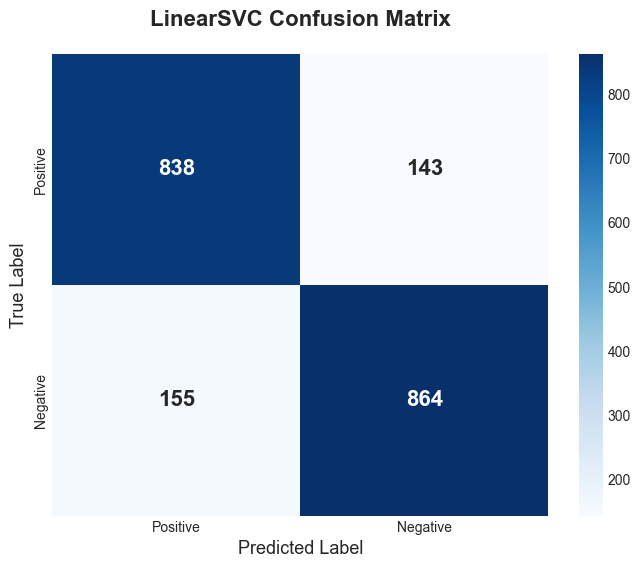

In [78]:
# ============================================================================
# STEP 8: MODEL EVALUATION - SVM
# ============================================================================
print("\n" + "="*80)
print("[STEP 8] Evaluating LinearSVC Model...")
print("="*80)

# 1. Accuracy and Report
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy Score (SVM): {svm_accuracy:.4f}")
print("\nClassification Report (SVM):\n", classification_report(y_test, y_pred_svm))

# 2. Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=['pos', 'neg'])

# 3. Plotting the Confusion Matrix (Single Figure Setup)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'], 
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('LinearSVC Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.show()

In [79]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid (range of C values to test)
param_grid = {'C': [0.01, 0.1, 1.0, 10.0, 100.0]}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    LinearSVC(random_state=88, max_iter=2000), 
    param_grid, 
    cv=5,                 # Use 5-fold cross-validation
    scoring='accuracy',   # Optimize for accuracy
    n_jobs=-1             # Use all available CPU cores
)

print("\nStarting Grid Search for LinearSVC C parameter...")
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_svm_model = grid_search.best_estimator_
best_c = grid_search.best_params_['C']

print(f"\nOptimal C parameter found: {best_c}")

# Predict and evaluate with the optimized model
y_pred_tuned_svm = best_svm_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned_svm)

print(f"Accuracy Score (Tuned SVM, C={best_c}): {tuned_accuracy:.4f}")


Starting Grid Search for LinearSVC C parameter...

Optimal C parameter found: 0.1
Accuracy Score (Tuned SVM, C=0.1): 0.8585
